In [17]:
# import for rosbag
%matplotlib inline
import os
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from rosbags.typesys import Stores, get_typestore
from dynus_interfaces.msg import DynTraj

In [18]:
def get_ekf_cov_q(data_dir, bag_file, topic):
    """
    Args:
        data_dir (str): directory where bag file is stored
        bag_file (str): name of bag file
        topic (str): topic name to extract `ekf_cov_q` data from

    Returns:
        ekf_cov_q_values (np.array): array of ekf_cov_q values
        timestamps (np.array): array of timestamps
    """
    
    # lists to store data
    ekf_cov_q_values = []
    timestamps = []
    
    # create reader instance and open for reading
    with Reader(os.path.join(data_dir, bag_file)) as reader:

        # topic and msgtype information is available on .connections list
        for connection in reader.connections:
            print(connection.topic, connection.msgtype)

        # iterate over messages
        for connection, _, rawdata in reader.messages():
            
            if connection.topic == topic:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                # Assuming ekf_cov_q is a list in the message structure
                ekf_cov_q_values.append(msg.ekf_cov_q)
                # Assuming timestamps are stored in the header
                timestamps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)
        
    # convert to numpy array
    ekf_cov_q_values = np.array(ekf_cov_q_values)
    timestamps = np.array(timestamps)

    return ekf_cov_q_values, timestamps

In [19]:
data_dir = "/media/kkondo/T7/dynus/sim/traj_pred"
bag_file = "multiagent_sim_11"
topic = "/trajs"

ekf_cov_q_values, timestamps = get_ekf_cov_q(data_dir, bag_file, topic)

/NX01/d435/depth/image_raw/compressedDepth sensor_msgs/msg/CompressedImage
/NX01/d435/free_cells_vis_array visualization_msgs/msg/MarkerArray
/NX01/d435/color/image_raw sensor_msgs/msg/Image
/NX01/d435/depth/image_raw sensor_msgs/msg/Image
/NX01/mid360_PointCloud2 sensor_msgs/msg/PointCloud2
/NX01/d435/depth/color/points sensor_msgs/msg/PointCloud2
/NX01/traj nav_msgs/msg/Path
/clock rosgraph_msgs/msg/Clock
/NX01/agent_pos visualization_msgs/msg/Marker
/NX01/robot_description std_msgs/msg/String
/NX01/point_G_term geometry_msgs/msg/PointStamped
/NX01/d435/color/camera_info sensor_msgs/msg/CameraInfo
/parameter_events rcl_interfaces/msg/ParameterEvent
/NX01/state dynus_interfaces/msg/State
/NX01/agent_initial_guess_pos visualization_msgs/msg/Marker
/trajs dynus_interfaces/msg/DynTraj
/rosout rcl_interfaces/msg/Log
/NX01/dummy_traj_pos visualization_msgs/msg/Marker
/tf_static tf2_msgs/msg/TFMessage
/NX01/mode dynus_interfaces/msg/Mode
/clicked_point geometry_msgs/msg/PointStamped
/NX01/g

/tmp/ipykernel_75770/1366648530.py:28: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


KeyError: 'dynus_interfaces/msg/DynTraj'

In [16]:
# ekf_cov_q_mean = np.mean(ekf_cov_q_values, axis=1)  # Modify as needed for your data

print(ekf_cov_q_values.shape)

plt.figure(figsize=(10, 6))
plt.plot(timestamps, ekf_cov_q_values[0], marker='o', linestyle='-', color='b')
plt.xlabel('Time (seconds)')
plt.ylabel('EKF Covariance (q)')
plt.title('EKF Covariance (q) over Time for Trajectories')
plt.grid(True)
plt.show()

(0,)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1000x600 with 0 Axes>

In [128]:
# function to get accel from bag file
def get_accel(data_dir, bag_file, topic):

    """
    Args:
        data_dir (str): directory where bag file is stored
        bag_file (str): name of bag file
        topic (str): topic name to extract accel data from

    Returns:
        accels (np.array): array of accels
        timestamps (np.array): array of timestamps
    """
    
    # lists to store data
    accels = []
    timestamps = []
    
    # create reader instance and open for reading
    with Reader(os.path.join(data_dir, bag_file)) as reader:

        # topic and msgtype information is available on .connections list
        # for connection in reader.connections:
        #     print(connection.topic, connection.msgtype)

        # iterate over messages
        for connection, timestamp, rawdata in reader.messages():
            
            if connection.topic == topic:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                accels.append([msg.accel.linear.x, msg.accel.linear.y, msg.accel.linear.z, msg.accel.angular.x, msg.accel.angular.y, msg.accel.angular.z])
                timestamps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)
        
    # convert to numpy array
    accels = np.array(accels)
    timestamps = np.array(timestamps)

    return accels, timestamps

In [129]:
# function for time synchronization and pose transformation
def sync_and_transform(ground_truth_poses, ground_truth_timestamps, estimate_poses, estimate_timestamps, ground_truth_twist, ground_truth_twist_timestamps, ground_truth_accel, ground_truth_accel_timestamps, sync_freq=10.0):

    # find the common timestamps
    start_time = estimate_timestamps[0] if estimate_timestamps[0] > ground_truth_timestamps[0] else ground_truth_timestamps[0]

    # find the end time
    end_time = estimate_timestamps[-1] if estimate_timestamps[-1] < ground_truth_timestamps[-1] else ground_truth_timestamps[-1]

    # find the base timsstamps
    timestamps_sync = np.arange(start_time, end_time, 1.0/sync_freq)

    # synchronize poses with timestamps
    ground_truth_poses_sync = []
    estimate_poses_sync = []
    ground_truth_twist_sync = []
    ground_truth_twist_accel_sync = []
    
    for timestamp in timestamps_sync:

        # find the index that is closest to the timestamp
        ground_truth_idx = np.argmin(np.abs(ground_truth_timestamps - timestamp))
        estimate_idx = np.argmin(np.abs(estimate_timestamps - timestamp))
        ground_truth_twist_idx = np.argmin(np.abs(ground_truth_twist_timestamps - timestamp))
        ground_truth_accel_idx = np.argmin(np.abs(ground_truth_accel_timestamps - timestamp))

        ground_truth_poses_sync.append(ground_truth_poses[ground_truth_idx])
        estimate_poses_sync.append(estimate_poses[estimate_idx])
        ground_truth_twist_sync.append(ground_truth_twist[ground_truth_twist_idx])
        ground_truth_twist_accel_sync.append(ground_truth_accel[ground_truth_accel_idx])

    # convert to numpy array
    ground_truth_poses_sync = np.array(ground_truth_poses_sync)
    estimate_poses_sync = np.array(estimate_poses_sync)
    ground_truth_twist_sync = np.array(ground_truth_twist_sync)
    ground_truth_twist_accel_sync = np.array(ground_truth_twist_accel_sync)

    return ground_truth_poses_sync, estimate_poses_sync, ground_truth_twist_sync, ground_truth_twist_accel_sync, timestamps_sync

In [179]:
# function to align the poses
def align_poses(ground_truth_poses, estimate_poses):

    # estimate-poses are in their own frame, where the first pose is the origin of the frame
    # ground-truth poses are in the world frame

    # world to livox frame
    R_wl = Rot.from_quat(ground_truth_poses[0, 3:]).as_matrix()
    t_wl = ground_truth_poses[0, :3]
    T_wl = np.eye(4)
    T_wl[:3, :3] = R_wl
    T_wl[:3, 3] = t_wl

    # print("************ debug ************")
    print("T_wl: ", T_wl)
    # print("************ debug ************")

    # transform the estimate poses
    estimate_poses_aligned = np.zeros_like(estimate_poses)
    for i in range(len(estimate_poses)):

        # livox to estimate frame
        R_le = Rot.from_quat(estimate_poses[i, 3:]).as_matrix()
        t_le = estimate_poses[i, :3]
        T_le = np.eye(4)
        T_le[:3, :3] = R_le
        T_le[:3, 3] = t_le

        # find T_we
        T_we = T_wl @ T_le
        estimate_poses_aligned[i, :3] = T_we[:3, 3]
        estimate_poses_aligned[i, 3:] = Rot.from_matrix(T_we[:3, :3]).as_quat()
        
    return estimate_poses_aligned

In [180]:
# function for plot
def plot_3d_poses(ground_truth_poses, estimate_poses, raw_estimate_poses=None):
    
    # create figure
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # compute rotation matrix from quaternion
    ground_truth_rotations = Rot.from_quat(ground_truth_poses[:, 3:]).as_matrix()
    estimate_rotations = Rot.from_quat(estimate_poses[:, 3:]).as_matrix()

    # plot
    for i in range(len(ground_truth_poses)):
        
        # plot points
        ax.scatter(ground_truth_poses[i, 0], ground_truth_poses[i, 1], ground_truth_poses[i, 2], color="blue", label="ground truth" if i == 0 else "")
        ax.scatter(estimate_poses[i, 0], estimate_poses[i, 1], estimate_poses[i, 2], color="red", label="estimate" if i == 0 else "")
        if raw_estimate_poses is not None:
            ax.scatter(raw_estimate_poses[i, 0], raw_estimate_poses[i, 1], raw_estimate_poses[i, 2], color="green")

        # plot ground truth
        ax.quiver(ground_truth_poses[i, 0], ground_truth_poses[i, 1], ground_truth_poses[i, 2], ground_truth_rotations[i, 0, :], ground_truth_rotations[i, 1, :], ground_truth_rotations[i, 2, :], color="blue")

        # plot estimate
        ax.quiver(estimate_poses[i, 0], estimate_poses[i, 1], estimate_poses[i, 2], estimate_rotations[i, 0, :], estimate_rotations[i, 1, :], estimate_rotations[i, 2, :], color="red")

        # plot raw estimate
        if raw_estimate_poses is not None:
            ax.quiver(raw_estimate_poses[i, 0], raw_estimate_poses[i, 1], raw_estimate_poses[i, 2], estimate_rotations[i, 0, :], estimate_rotations[i, 1, :], estimate_rotations[i, 2, :], color="green")

        # plot lines connecting the points from the previous to the current
        if i > 0:
            ax.plot([ground_truth_poses[i-1, 0], ground_truth_poses[i, 0]], [ground_truth_poses[i-1, 1], ground_truth_poses[i, 1]], [ground_truth_poses[i-1, 2], ground_truth_poses[i, 2]], color="blue")
            ax.plot([estimate_poses[i-1, 0], estimate_poses[i, 0]], [estimate_poses[i-1, 1], estimate_poses[i, 1]], [estimate_poses[i-1, 2], estimate_poses[i, 2]], color="red")

    # set labels
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    
    # set legend
    ax.legend()

    # equal axis
    # ax.set_box_aspect([1,1,1])

    # set limits
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(0, 3)

    # set title
    ax.set_title("Pose comparison")
    
    # show plot
    plt.show()

In [181]:
# function for plot
def plot_poses(ground_truth_poses, estimate_poses, timestamps_sync, plot_freq=10.0, raw_estimate_poses=None):
    
    # create figure
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(211)
    
    # plot for position
    ax1.plot(ground_truth_poses[:, 0], color="blue", label="ground truth x")
    ax1.plot(ground_truth_poses[:, 1], color="slateblue", label="ground truth y")
    ax1.plot(ground_truth_poses[:, 2], color="darkslateblue", label="ground truth z")
    ax1.plot(estimate_poses[:, 0], color="red", label="estimate x")
    ax1.plot(estimate_poses[:, 1], color="tomato", label="estimate y")
    ax1.plot(estimate_poses[:, 2], color="sienna", label="estimate z")

    # plot for orientation (rpy)
    ax2 = fig.add_subplot(212)
    euler_gt = Rot.from_quat(ground_truth_poses[:, 3:]).as_euler("ZYX", degrees=True)
    euler_est = Rot.from_quat(estimate_poses[:, 3:]).as_euler("ZYX", degrees=True)

    ax2.plot(euler_gt[:, 0], color="blue", label="ground truth roll")
    ax2.plot(euler_gt[:, 1], color="slateblue", label="ground truth pitch")
    ax2.plot(euler_gt[:, 2], color="darkslateblue", label="ground truth yaw")
    ax2.plot(euler_est[:, 0], color="red", label="estimate roll")
    ax2.plot(euler_est[:, 1], color="tomato", label="estimate pitch")
    ax2.plot(euler_est[:, 2], color="sienna", label="estimate yaw")

    # set legend
    ax1.legend()
    ax2.legend()

    # set labels
    ax1.set_ylabel("Position [m]")
    ax1.set_xlabel("Time [s]")
    ax2.set_ylabel("Orientation [deg]")
    ax2.set_xlabel("Time [s]")

    # set label ticks
    # x axis should start from 0 to the end based on timestamps_sync
    start_time = timestamps_sync[0]
    end_time = timestamps_sync[-1]
    ax1.set_xticks(np.arange(0, len(timestamps_sync), ground_truth_poses.shape[0] / plot_freq))
    ax1.set_xticklabels(np.round(np.arange(0, end_time - start_time, (end_time - start_time) / plot_freq), 1))
    ax2.set_xticks(np.arange(0, len(timestamps_sync), ground_truth_poses.shape[0] / plot_freq))
    ax2.set_xticklabels(np.round(np.arange(0, end_time - start_time, (end_time - start_time) / plot_freq), 1))

    # show plot
    plt.show()

In [182]:
# function to compute the error
def plot_error(ground_truth_poses, estimate_poses, ground_truth_twist_sync, ground_truth_accel_sync, timestamps_sync, plot_freq=10.0):

    position_error = np.linalg.norm(ground_truth_poses[:, :3] - estimate_poses[:, :3], axis=1)

    # compute the orientation error (frobenius norm of the rotation_matrix_gt @ rotation_matrix_est.T - I)
    euler_gt = Rot.from_quat(ground_truth_poses[:, 3:]).as_euler("ZYX", degrees=True)
    euler_est = Rot.from_quat(estimate_poses[:, 3:]).as_euler("ZYX", degrees=True)

    roll_error = np.abs(euler_gt[:, 0] - euler_est[:, 0])
    pitch_error = np.abs(euler_gt[:, 1] - euler_est[:, 1])
    yaw_error = np.abs(euler_gt[:, 2] - euler_est[:, 2])

    # wrap the angles
    for i in range(len(roll_error)):
        if roll_error[i] > 180:
            roll_error[i] = 360 - roll_error[i]
        if pitch_error[i] > 180:
            pitch_error[i] = 360 - pitch_error[i]
        if yaw_error[i] > 180:
            yaw_error[i] = 360 - yaw_error[i]

    # plot the error
    fig, ax = plt.subplots(4, 1, figsize=(15, 15))
    
    # x axis should start from 0 to the end based on timestamps_sync
    start_time = timestamps_sync[0]
    end_time = timestamps_sync[-1]
    for i in range(4):
        ax[i].set_xticks(np.arange(0, len(position_error), len(position_error) / plot_freq))
        ax[i].set_xticklabels(np.round(np.arange(0, end_time - start_time, (end_time - start_time) / plot_freq), 1))

    # plot
    ax[0].plot(position_error)
    ax[0].set_title("Position error")
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Error [m]")
    ax[1].plot(roll_error, label="Roll")
    ax[1].plot(pitch_error, label="Pitch")
    ax[1].plot(yaw_error, label="Yaw")
    ax[1].set_title("Rotation error")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Error [deg]")
    ax[1].legend()
    ax[2].plot(ground_truth_twist_sync[:, 0], label="linear x")
    ax[2].plot(ground_truth_twist_sync[:, 1], label="linear y")
    ax[2].plot(ground_truth_twist_sync[:, 2], label="linear z")
    ax[2].set_title("Linear velocity")
    ax[2].set_xlabel("Time [s]")
    ax[2].set_ylabel("Lin vel [m/s]")
    ax[3].plot(ground_truth_twist_sync[:, 3], label="angular x")
    ax[3].plot(ground_truth_twist_sync[:, 4], label="angular y")
    ax[3].plot(ground_truth_twist_sync[:, 5], label="angular z")
    ax[3].set_title("Angular velocity")
    ax[3].set_xlabel("Time [s]")
    ax[3].set_ylabel("Ang vel [rad/s]")

    # make more space between the plots
    plt.tight_layout()
    
    plt.show()

In [183]:
# main

def main(data_dir, test_num, sync_freq=10.0, plot_freq=10.0):

    # get poses
    ground_truth_poses, ground_truth_timestamps = get_pose(data_dir, f"test{test_num}_vicon", "/NX04/world")
    ground_truth_twist, ground_truth_twist_timestamps = get_twist(data_dir, f"test{test_num}_vicon", "/NX04/mocap/twist")
    ground_truth_accel, ground_truth_accel_timestamps = get_accel(data_dir, f"test{test_num}_vicon", "/NX04/mocap/accel")
    estimate_poses, estimate_timestamps = get_pose(data_dir, f"test{test_num}_onboard", "/dlio/odom_node/pose")

    # synchronize and transform
    ground_truth_poses_sync, estimate_poses_sync, ground_truth_twist_sync, ground_truth_accel_sync, timestamps_sync = sync_and_transform(ground_truth_poses, ground_truth_timestamps, estimate_poses, estimate_timestamps, ground_truth_twist, ground_truth_twist_timestamps, ground_truth_accel, ground_truth_accel_timestamps, sync_freq=sync_freq)
    assert ground_truth_poses_sync.shape[0] == estimate_poses_sync.shape[0] == ground_truth_twist_sync.shape[0] == ground_truth_accel_sync.shape[0]

    # align frames of reference
    estimate_poses_aligned = align_poses(ground_truth_poses_sync, estimate_poses_sync)
    
    # plot
    plot_poses(ground_truth_poses_sync, estimate_poses_aligned, timestamps_sync, plot_freq=plot_freq)
    plot_3d_poses(ground_truth_poses_sync, estimate_poses_aligned)
    
    # compute error
    plot_error(ground_truth_poses_sync, estimate_poses_aligned, ground_truth_twist_sync, ground_truth_accel_sync, timestamps_sync, plot_freq=plot_freq)

/rosout rosgraph_msgs/msg/Log
/rosout rosgraph_msgs/msg/Log
/NX04/world geometry_msgs/msg/PoseStamped
/NX04/mocap/accel geometry_msgs/msg/AccelStamped
/NX04/mocap/twist geometry_msgs/msg/TwistStamped
/NX04/mocap/status mocap/msg/Status
/tf tf2_msgs/msg/TFMessage
/NX04/goal snapstack_msgs/msg/Goal
/NX04/joy sensor_msgs/msg/Joy
/NX04/attcmd snapstack_msgs/msg/AttitudeCommand
/NX04/log snapstack_msgs/msg/ControlLog
/NX04/imu snapstack_msgs/msg/IMU
/NX04/odometry nav_msgs/msg/Odometry
/NX04/state snapstack_msgs/msg/State
/NX04/timefilter snapstack_msgs/msg/TimeFilter
/NX04/motors snapstack_msgs/msg/Motors
/NX04/smc snapstack_msgs/msg/SMCData
/rosout_agg rosgraph_msgs/msg/Log
/diagnostics diagnostic_msgs/msg/DiagnosticArray


/tmp/ipykernel_648450/375832653.py:30: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  msg = deserialize_cdr(rawdata, connection.msgtype)


/dlio/odom_node/pose geometry_msgs/msg/PoseStamped
/dlio/odom_node/odom nav_msgs/msg/Odometry
/tf tf2_msgs/msg/TFMessage
/dlio/odom_node/keyframes geometry_msgs/msg/PoseArray
/events/write_split rosbag2_interfaces/msg/WriteSplitEvent
/dlio/odom_node/path nav_msgs/msg/Path
/livox/imu sensor_msgs/msg/Imu
/dlio/odom_node/pointcloud/deskewed sensor_msgs/msg/PointCloud2
/livox/lidar sensor_msgs/msg/PointCloud2
/map sensor_msgs/msg/PointCloud2
/dlio/odom_node/pointcloud/keyframe sensor_msgs/msg/PointCloud2
/parameter_events rcl_interfaces/msg/ParameterEvent
/rosout rcl_interfaces/msg/Log
T_wl:  [[-7.61125383e-01 -6.48551579e-01 -8.30664571e-03  1.21380824e+00]
 [ 6.48521040e-01 -7.61170491e-01  6.32009529e-03 -3.31189012e+00]
 [-1.04216814e-02 -5.76649569e-04  9.99945527e-01  9.62917456e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_210:  [[ 1.         0.         0.         0.       ]
 [ 0.        -0.8660254  0.5        0.       ]
 [ 0.        -0.5       -0.866025

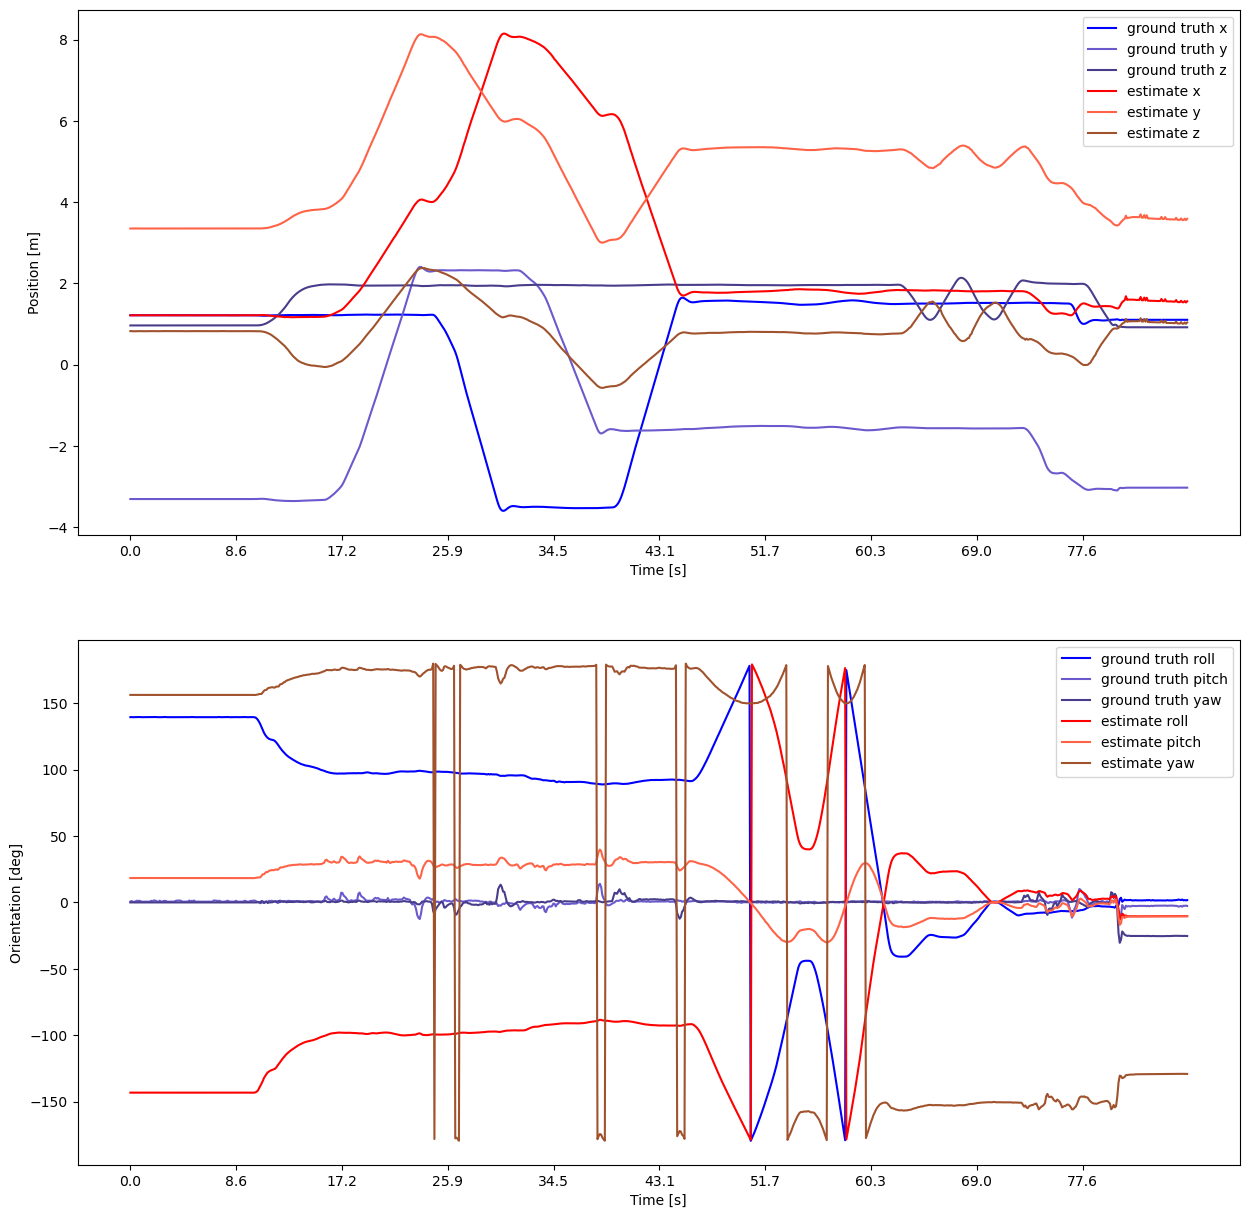

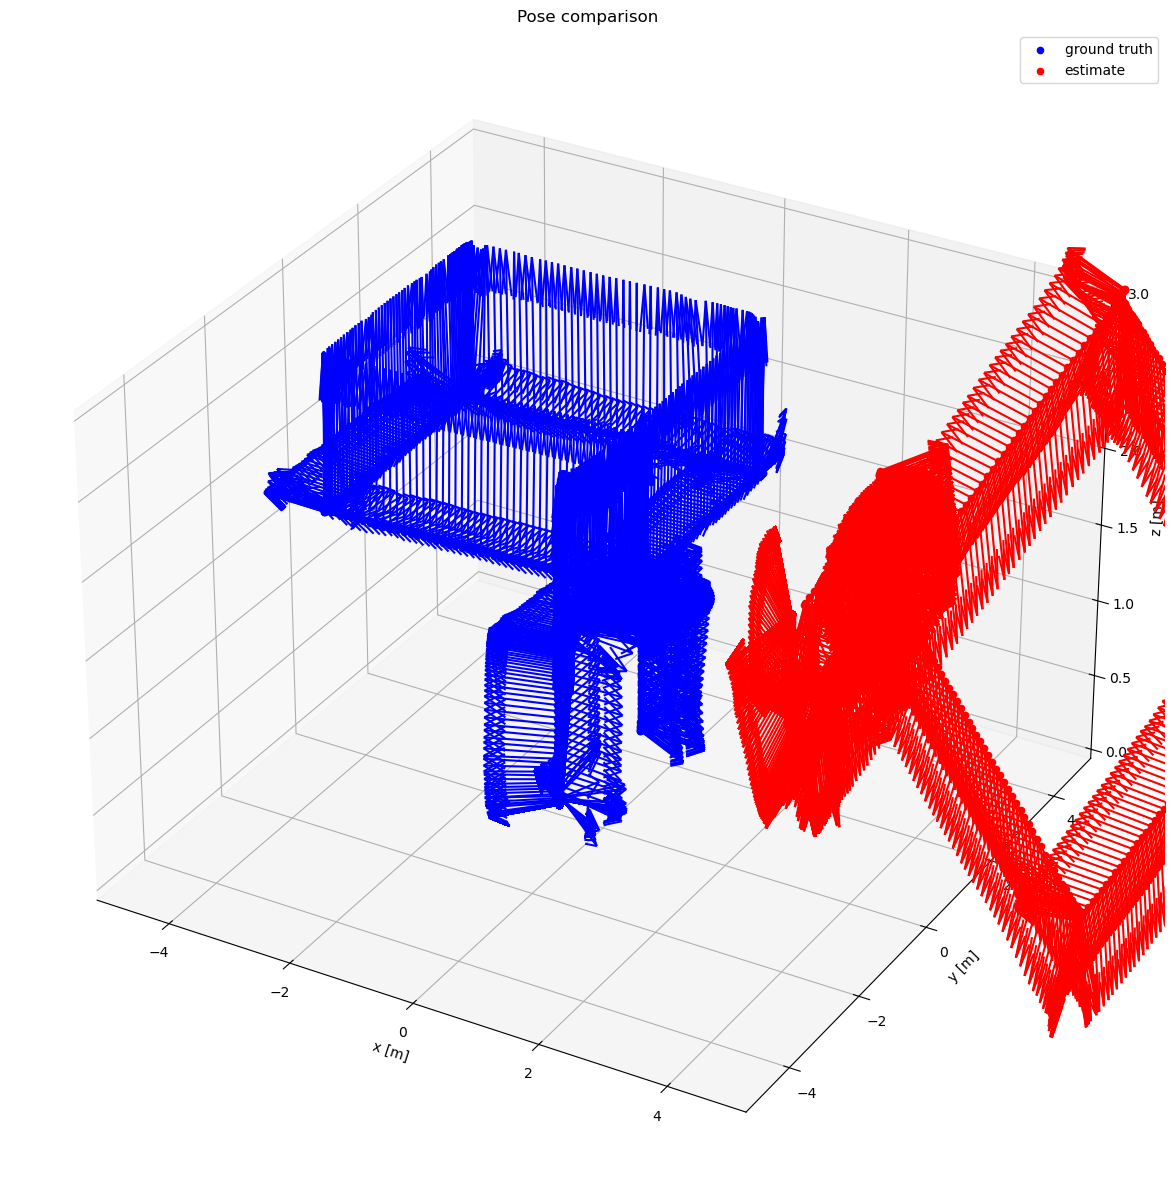

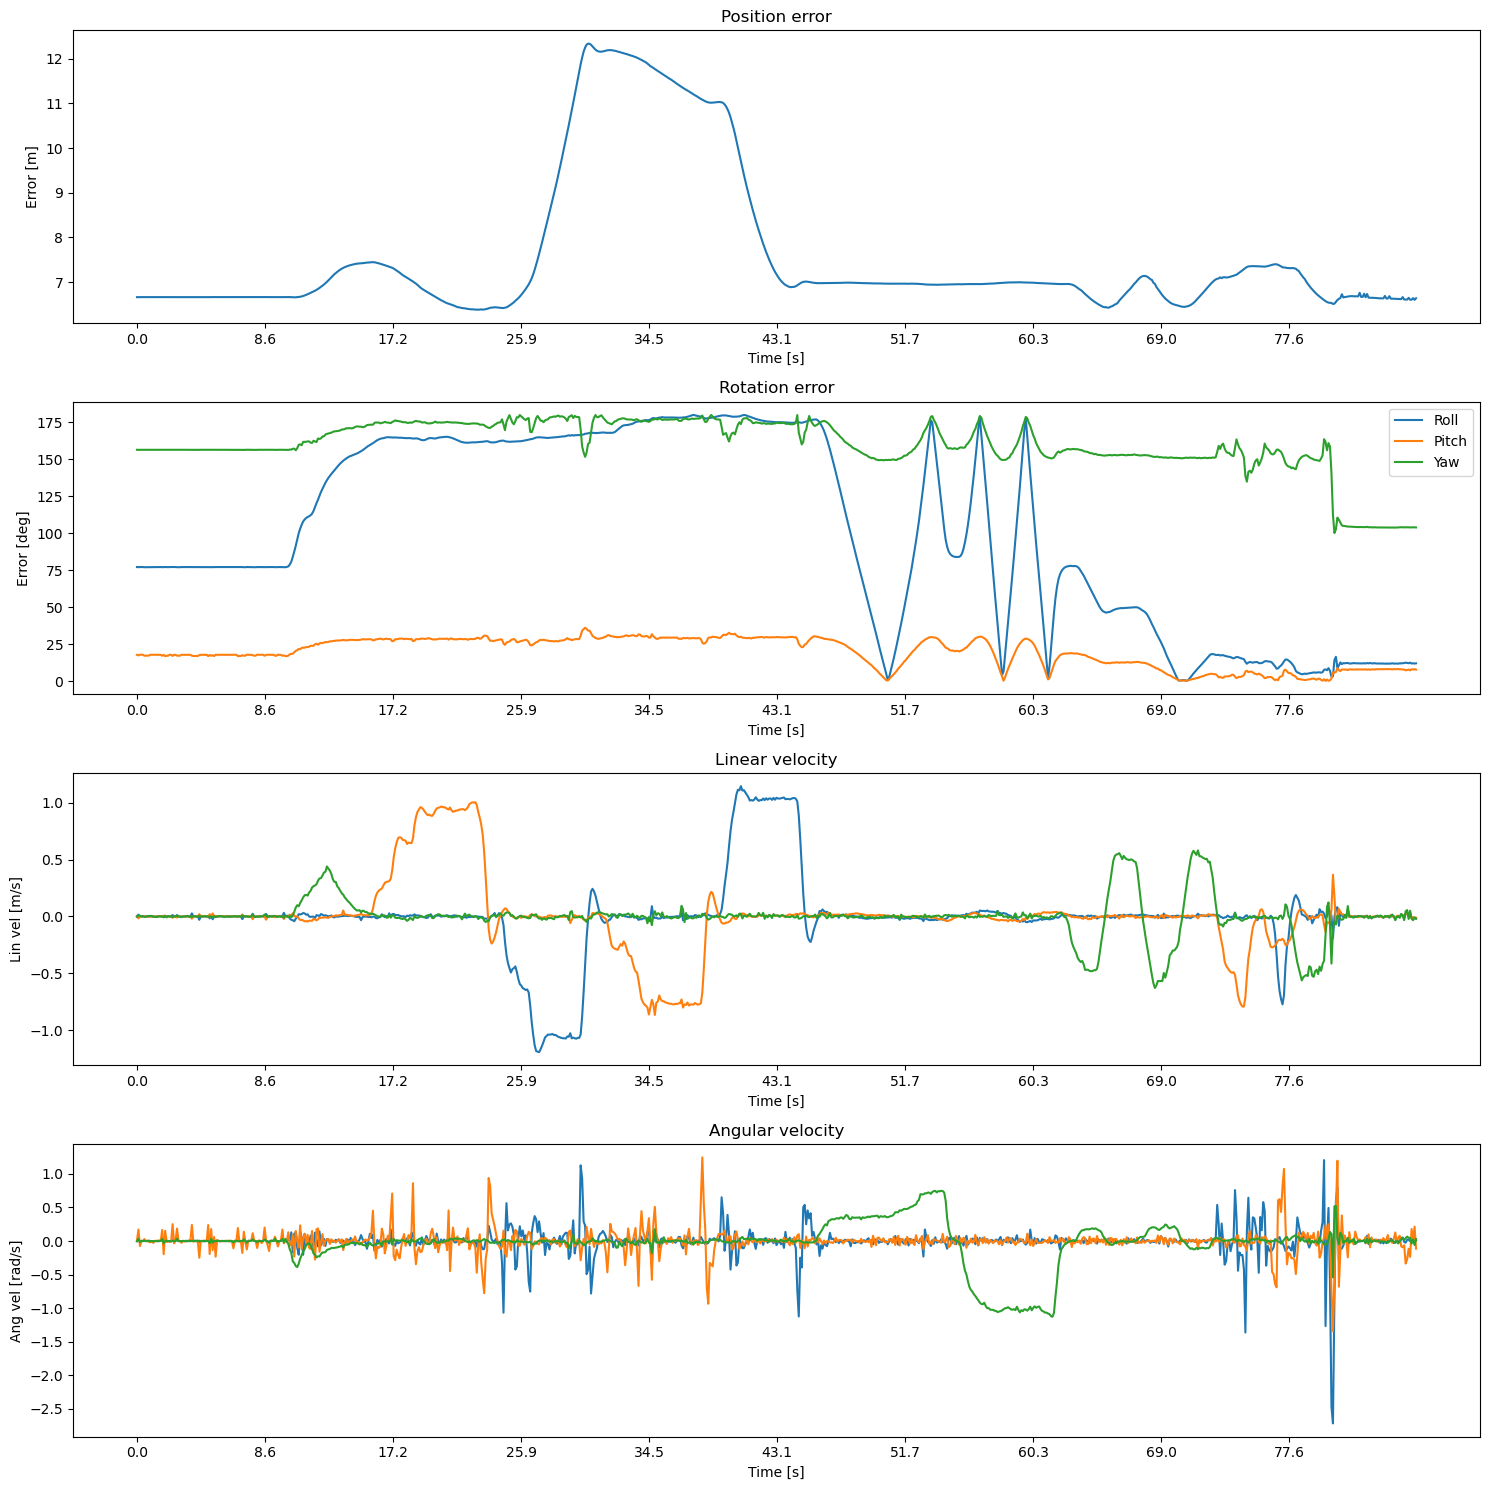

In [184]:
# run main

# constants
data_dir = "/home/kkondo/data/bags/lidar_test/drone_tests"
sync_freq = 10.0 # Hz
plot_freq = 10.0 # Hz

# variables
test_nums = ["3"]
for test_num in test_nums:
    main(data_dir, test_num, sync_freq=sync_freq, plot_freq=plot_freq)